100%|██████████| 1500000/1500000 [20:07<00:00, 1242.36it/s]
<ipython-input-5-47a2b6952ad7>:352: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig4.savefig('wjk.pdf')


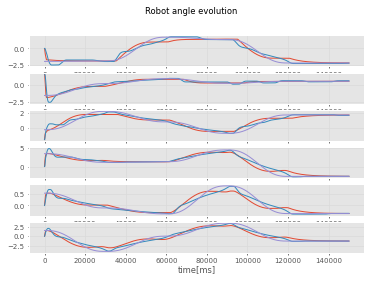

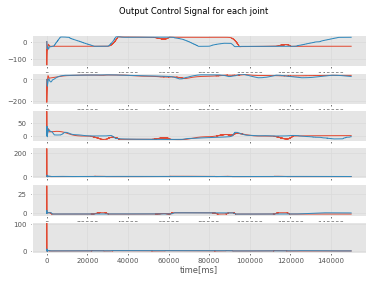

/Users/alex-cic/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


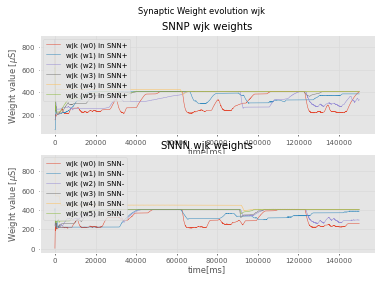

In [5]:
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
import roboticstoolbox as rtb

class RSTDP:
    Ap = 1
    Am = -Ap
    tE = 10
    wmin = 1            #peso sinaptico minimo 1mS (Conductancia)
    wmax = 1000         #peso sinaptico max 1000mS (Conductancia)
    def __init__(self, w_initial):
        self.w = w_initial        #peso sinaptico inicial, inicializado de manera aleatoria
        self.E = 0             #traza de egibilidad
        self.dE = 0
        self.w_hist = []
    
    def update(self, dd_prev, dd_post, R):
        Ap = self.Ap
        Am = self.Am
        tE = self.tE

        w = self.w
        E = self.E

        Wpre =  Ap * dd_prev 
        Wpost = Am * dd_post
        dE = (-E/tE) + Wpre + Wpost
        E = E + dt * dE
        dw = R * E
        w = w + dt * dw

        if(w<self.wmin):
            w = 1
        elif(w>self.wmax):
            w = self.wmax

        self.E = E
        self.w = w
        self.w_hist.append(w)


class StepFowardEncoder:
    def __init__(self, thr, Ic):
        self.base = 0
        self.thr = thr
        self.Ic = Ic
    
    def encode(self, x):
        IcP = 0
        IcN = 0
        base = self.base
        thr = self.thr
        if(x > (base + thr)):
            IcP = self.Ic
            base = base + thr
        elif(x < (base - thr)):
            IcN = self.Ic
            base = base - thr
        self.base = base
        return [IcP, IcN]

class StepFowardDecoder:
    def __init__(self, thr):
        self.base = 0
        self.thr = thr

    def decode(self, spk_pos, spk_neg):
        thr = self.thr
        base = self.base
        if(spk_pos == 1):
            base = self.base +  thr
        elif(spk_neg == 1):
            base = self.base - thr
        self.base = base
        return base


class LIF:
    #Modelo LIF 
    Rm = 10              #Resistencia de membrana 10MOhms (10e6)
    Cm = 1               #Capacitancia de membrana 1nF (1e-9)
    tm = Rm * Cm         #constante temporal membrana  [ms]
    El = -70             #voltaje de reposo  mV
    vreset = -75         #voltaje de reset   mV
    vth = -55            #voltaje de  umbral mV
    vspike = 20          #voltaje de disparo m
    T = 50
    def __init__(self):
        self.V = self.El
        self.tf = []
        self.frec_hist = []

    def sim_neuron(p, t, Isyn):
        V = p.V
        dV = (p.El - V + p.Rm * Isyn)/p.tm
        V = V + dt * dV
        diracDelta = 0
        if(V >= p.vth):
            V = p.vreset               #se resetea el voltaje de membrana
            diracDelta = 1             #lo mismo que diracDelta con t=tf
            p.tf.append(t)           #agregando el nuevo tiempo de disparo
        
        #calculando la frecuencia
        p.checkFiringTimes(t)
        f = (len(p.tf)) * (1000/p.T)

        p.frec_hist.append(f)
        p.V = V
        return diracDelta
    
    def checkFiringTimes(self, t):
        #metodo que solo guarda los tiempos de disparo de neurona que estan dentro del lapso T
        tf = np.array(self.tf)
        new_tf = tf[(t - tf) < self.T]
        self.tf = new_tf.tolist()
        
class LIFspk(LIF):
    #Modelo LIF aumentado que calcula la corriente de entrada en funcion de los disparos
    def __init__(self):
        self.V = self.El
        self.Isyn = 0
        self.tf = []
        self.frec_hist = []

    def sim_neuron(p, t, w_dd):
        Isyn = p.Isyn
        V = p.V

        dIsyn = (-Isyn + p.Cm * w_dd)/p.tm
        dV = (p.El - V + p.Rm * Isyn)/p.tm
        Isyn = Isyn + dt * dIsyn
        V = V + dt * dV

        diracDelta = 0
        if(V >= p.vth):
            V = p.vreset               #se resetea el voltaje de membrana
            diracDelta = 1                 #lo mismo que diracDelta con t=tf
            p.tf.append(t)           #agregando el nuevo tiempo de disparo
        
        #calculando la frecuencia
        p.checkFiringTimes(t)
        f = (len(p.tf)) * (1000/p.T)
        p.frec_hist.append(f)

        p.Isyn = Isyn
        p.V = V
        return diracDelta


class RobotObject:
    def __init__(self):
        self.model = rtb.models.DH.Puma560()
        self.q = self.model.qr            #declarando posicion inicial
        self.qd = np.zeros(self.model.n)
        self.n = self.model.n
        self.q_hist = []
        self.tau_hist = []

    def simulate(self, t, tau):
        self.tau_hist.append(tau)
        q = self.q
        qd = self.qd
        
        qdd = self.model.accel(q, qd, tau)
        qd = qd + qdd * dt * 0.001 
        q = q + qd * dt *0.001

        self.q = q
        self.qd = qd

        self.q_hist.append(q)

        return q, qd


class Network:
    def __init__(self, q, n):
        self.q = q
        self.n = n
        self.i_layer = [LIF() for i in range(q)]
        self.j_layer = [LIFspk() for j in range(n)]
        self.k_layer = [LIFspk() for k in range(q)]

        self.wij = np.empty((q, n), dtype = object)
        wij_initial = np.random.normal(0, 500, size=(q, n))+500
        wij_initial = wij_initial*1000/np.linalg.norm(wij_initial)
        for (i,j), syn in np.ndenumerate(self.wij):
            self.wij[i,j] = RSTDP(wij_initial[i,j])

        wjk_initial = np.random.normal(0, 500, size=(n,q))+500
        wjk_initial = wjk_initial*1000/np.linalg.norm(wjk_initial)
        self.wjk = np.empty((n, q), dtype = object)
        for (j,k), syn in np.ndenumerate(self.wjk):
            self.wjk[j,k] = RSTDP(wjk_initial[j,k])

        self.Rij = np.ones(n)
        self.Rjk = np.ones(q)
        self.Rij_hist = []
        self.Rjk_hist = []

    def get_wij(self):
        w_ij = np.empty((self.q, self.n), dtype = float)
        for (i,j), syn in np.ndenumerate(self.wij):
            w_ij[i,j] = syn.w
        return w_ij

    def get_wjk(self):
        w_jk = np.empty((self.n, self.q), dtype = float)
        for (j,k), syn in np.ndenumerate(self.wjk):
            w_jk[j,k] = syn.w
        return w_jk

    def simulate(self, t, Ic_vector):
        tif = []
        for i, neuron in enumerate(self.i_layer):
            tf = neuron.sim_neuron(t,Ic_vector[i])
            tif.append(tf)

        #simulando disparos capa j
        tjf = []
        wij = self.get_wij()
        for j, neuron in enumerate(self.j_layer):
            w_dd = np.dot(tif, wij[:,j])
            tf = neuron.sim_neuron(t,w_dd)
            tjf.append(tf)
        
        #simulando disparos capa k
        tkf = []
        wjk = self.get_wjk()
        for k, neuron in enumerate(self.k_layer):
            w_dd = np.dot(tjf, wjk[:,k])
            tf = neuron.sim_neuron(t,w_dd)
            tkf.append(tf)
        
        #actualizando sinapsis wjk
        for (i,j), syn in np.ndenumerate(self.wij):
            syn.update(tif[i], tjf[j], self.Rij[j])

        #actualizando sinapsis wjk
        for (j,k), syn in np.ndenumerate(self.wjk):
            syn.update(tjf[j], tkf[k], self.Rjk[k])
        
        return np.array(tkf) 

    # def backprop(self, Rjk):
    #     Rij = []
    #     wjk = self.get_wjk()
    #     for j in range(wjk.shape[0]): 
    #         R = np.dot(wjk[j,:], Rjk)/np.sum(wjk[j,:])
    #         Rij.append(R)
        
    #     self.Rij = Rij
    #     self.Rjk = Rjk
    #     self.Rij_hist.append(Rij)
    #     self.Rjk_hist.append(Rjk)



def PID(e, ie, de):
    Kp = np.ones(6) * 70
    Ki = np.ones(6) * 10
    Kd = np.ones(6) * 20
    return Kp * e + Ki * ie + Kd * de


# robot controlado por PID
robot_PID = RobotObject()
tau_PID = np.zeros(robot_PID.n)
iq_PID = np.zeros(robot_PID.n)


# #robot controlado por SNN
robot_SNN = RobotObject()
tau_SNN = np.zeros(robot_SNN.n)
iq_SNN = np.zeros(robot_SNN.n)

#Redes parte proporcional
SNNP = Network(robot_SNN.n)
SNNN = Network(robot_SNN.n)

encoders = [StepFowardEncoder(0.001) for i in range(robot_SNN.n)]
decoders = [StepFowardDecoder(0.01) for i in range(robot_SNN.n)]

#variables temporales
dt = 0.1
t_ini = 0
t_fin = 25000
tiempo = np.arange(t_ini, t_fin, dt)

#trayectoria deseada
q_1 = np.array([-1.94382684, -1.52031999, -0.24377439,  3.43299013,  0.51468585,  1.49069452])
q_2 = np.array([1.87313157,  0.18879081,  2.2355793 ,  1.12178102, -0.10365774, -1.8645068 ])
path1 = rtb.jtraj(q_1, q_2, int(15000 * (1/dt)))
path2 = rtb.jtraj(q_2, q_2, int(10000 * (1/dt)))
qdes_hist = np.concatenate((path1.q,path2.q))
dqdes_hist = np.concatenate((path1.qd,path2.qd))


# #variables temporales
# dt = 0.1
# t_ini = 0
# t_fin = 150000
# tiempo = np.arange(t_ini, t_fin, dt)

# #trayectoria deseada
# q_1 = np.array([-1.94382684, -1.52031999, -0.24377439,  3.43299013,  0.51468585,  1.49069452])
# q_2 = np.array([-1.87313157,  0.18879081,  2.2355793 ,  1.12178102, -0.10365774, -3.8645068 ])
# q_3 = np.array([ 1.70173362,  0.90558959,  0.81099364,  1.28551268, -0.35163011,  0.03535112])
# q_4 = np.array([ 1.33604039,  0.23335995, -0.73056244,  4.44151628,  0.81889472,  3.35916372])
# q_5 = np.array([-2.18274108,  0.53138642,  1.74804297, -2.63692093, -0.33769587, -1.22758716])
# path1 = rtb.jtraj(q_1, q_2, int(30000 * (1/dt)))
# path2 = rtb.jtraj(q_2, q_3, int(30000 * (1/dt)))
# path3 = rtb.jtraj(q_3, q_4, int(30000 * (1/dt)))
# path4 = rtb.jtraj(q_4, q_5, int(30000 * (1/dt)))
# path5 = rtb.jtraj(q_5, q_5, int(30000 * (1/dt)))
# qdes_hist = np.concatenate((path1.q,path2.q, path3.q, path4.q, path5.q))
# dqdes_hist = np.concatenate((path1.qd,path2.qd, path3.qd, path4.qd, path5.qd))
# changePoint = 60000 * (1/dt)
# offsetMass = 0.25

teqdm = range(len(tiempo))        
for a in tqdm(teqdm):
    t = tiempo[a]

    #simulando SNN-PID
    q_des = qdes_hist[a]
    qd_des = dqdes_hist[a]
    q, qd = robot_SNN.simulate(t, tau_SNN)
    #calculando el error
    eq_SNN = q_des - q
    deq_SNN = qd_des - qd
    iq_SNN = iq_SNN + eq_SNN * dt * 0.001

    #entregando senal a los encoders
    IcP = []
    IcN = []
    for n, enc in enumerate(encoders):
        [IcP_n, IcN_n] = enc.encode(eq_SNN[n] + iq_SNN[n] + deq_SNN[n])
        IcP.append(IcP_n)
        IcN.append(IcN_n)
    tf_pos = SNNP.simulate(t, IcP)                                  #simulando red positiva
    tf_neg = SNNN.simulate(t, IcN)                                  #simulando red negativa

    #decodificando senal de la red y asignando nuevo tau
    new_tau = []
    for n, decoder in enumerate(decoders):
        new_tau.append(decoder.decode(tf_pos[n], tf_neg[n]))
    
    tau_SNN = np.array(new_tau)

    #simulando PID normal
    q_PID, qd_PID = robot_PID.simulate(t,tau_PID)
    eq_PID = q_des - q_PID
    deq_PID = qd_des - qd_PID
    iq_PID = iq_PID + eq_PID * dt * 0.001
    tau_PID = PID(eq_PID, iq_PID, deq_PID)
    
    #si llegamos a la segunda trayectoria, cambiar masa de ambos robots
    # if(a == changePoint):
    #     for i, link in enumerate(robot_SNN.model.links):
    #         link.m = link.m + offsetMass
    #     for i, link in enumerate(robot_PID.model.links):
    #         link.m = link.m + offsetMass

q_hist = np.matrix(robot_SNN.q_hist)
q_PID_hist = np.matrix(robot_PID.q_hist)
fig, ax = plt.subplots(robot_SNN.n)
for i in range(robot_SNN.n):
    ax[i].plot(tiempo, q_PID_hist[:,i],linewidth = 1, label='PID q%s' % i)
    ax[i].plot(tiempo, q_hist[:,i],linewidth = 1, label='SNN q%s' % i)
    ax[i].plot(tiempo, qdes_hist[:,i],linewidth = 1, label='Path Desired q%s' % i)
    # ax[i].legend()
    ax[i].set(xlabel = 'time[ms]' , ylabel = '')
fig.suptitle('Robot angle evolution')
fig.savefig('q.pdf')



tau_hist = np.matrix(robot_SNN.tau_hist)
tau_PID_hist = np.matrix(robot_PID.tau_hist)
fig2, ax2 = plt.subplots(robot_SNN.n)
for i in range(robot_SNN.n):
    ax2[i].plot(tiempo, tau_PID_hist[:,i], linewidth = 1, label = 'PID $\tau_%s$' % i)
    ax2[i].plot(tiempo, tau_hist[:,i], linewidth = 1, label = 'SNN $\tau_%s$' % i)
    # ax2[i].legend()
    ax2[i].set(xlabel = 'time[ms]' , ylabel = '')
fig2.suptitle('Output Control Signal for each joint')
fig2.savefig('tau.pdf')



fig4, ax4 = plt.subplots(2)
for i, syn in enumerate(SNNP.wjk):
    ax4[0].plot(tiempo,syn.w_hist,linewidth = 0.5, label = 'wjk (w%s) in SNN+' % (i))
for i, syn in enumerate(SNNN.wjk):
    ax4[1].plot(tiempo,syn.w_hist,linewidth = 0.5, label = 'wjk (w%s) in SNN-' % (i))
ax4[0].legend()
ax4[1].legend()
ax4[0].set(xlabel = 'time[ms]' , ylabel = 'Weight value [$\mu$S]')
ax4[1].set(xlabel = 'time[ms]' , ylabel = 'Weight value [$\mu$S]')
ax4[0].set_title('SNNP wjk weights')
ax4[1].set_title('SNNN wjk weights')
fig4.suptitle('Synaptic Weight evolution wjk')
fig4.savefig('wjk.pdf')


fig5, (ax5) = plt.subplots(2)
for j, neuron in enumerate(SNNP.j_layer):
    ax5[0].plot(tiempo,neuron.frec_hist,linewidth = 0.5, label = 'j-neuron (%s)in SNN+' % (j))
for j, neuron in enumerate(SNNN.j_layer):
    ax5[1].plot(tiempo,neuron.frec_hist,linewidth = 0.5, label = 'j-neuron (%s)in SNN-' % (j))
# ax5[0].legend()
# ax5[1].legend()
ax5[0].set(xlabel = 'time[ms]' , ylabel = 'Spike Frecuency [Hz]')
ax5[1].set(xlabel = 'time[ms]' , ylabel = 'Spike Frecuency [Hz]')
fig5.suptitle('Spike frecuency j-layer SNN+ and SNN-')
fig5.savefig('FrecSNNJlayer.pdf')


fig6, (ax6) = plt.subplots(2)
for j, neuron in enumerate(SNNP.k_layer):
    ax6[0].plot(tiempo,neuron.frec_hist,linewidth = 0.5, label = 'k-neuron (%s)in SNN+' % (j))
for j, neuron in enumerate(SNNN.k_layer):
    ax6[1].plot(tiempo,neuron.frec_hist,linewidth = 0.5, label = 'k-neuron (%s)in SNN-' % (j))
# ax6[0].legend()
# ax6[1].legend()
ax6[0].set(xlabel = 'time[ms]' , ylabel = 'Spike Frecuency [Hz]')
ax6[1].set(xlabel = 'time[ms]' , ylabel = 'Spike Frecuency [Hz]')
fig6.suptitle('Spike frecuency k-layer SNN+ and SNN-')
fig6.savefig('FrecSNNKlayer.pdf')
